In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [33]:
fake = pd.read_csv("news.csv")
true = pd.read_csv("news.csv")

In [34]:
print(fake.shape)

(6335, 4)


In [35]:
print(true.shape)

(6335, 4)


# Data Cleaning and Preparation

In [36]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [37]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(12670, 5)

In [38]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [39]:
# Check the data
data.head()

,Unnamed: 0,title,text,label,target
0,8585,Alien Visitors? No Explanation for Mysterious ...,Kaboom! Meteor Turns Night Into Day in Arizona...,FAKE,fake
1,5513,"If Donald Trump Wins The Election, It Will Be ...","If Donald Trump Wins The Election, It Will Be ...",FAKE,fake
2,668,Was California The Last Weekend At Bernie's Ho...,Was California The Last Weekend At Bernie's Ho...,REAL,true
3,2921,Why the Iraq offensive will fail,American officials said this week they plan to...,REAL,fake
4,7589,“I’ve Always Been An Admirer Of Donald Trump” ...,We Use Cookies: Our policy [X] “I’ve Always Be...,FAKE,true


In [40]:
# Removing the date (we won't use it for the analysis)
data.drop(["Unnamed: 0"],axis=1,inplace=True)
data.head()

,title,text,label,target
0,Alien Visitors? No Explanation for Mysterious ...,Kaboom! Meteor Turns Night Into Day in Arizona...,FAKE,fake
1,"If Donald Trump Wins The Election, It Will Be ...","If Donald Trump Wins The Election, It Will Be ...",FAKE,fake
2,Was California The Last Weekend At Bernie's Ho...,Was California The Last Weekend At Bernie's Ho...,REAL,true
3,Why the Iraq offensive will fail,American officials said this week they plan to...,REAL,fake
4,“I’ve Always Been An Admirer Of Donald Trump” ...,We Use Cookies: Our policy [X] “I’ve Always Be...,FAKE,true


In [41]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,label,target
0,Kaboom! Meteor Turns Night Into Day in Arizona...,FAKE,fake
1,"If Donald Trump Wins The Election, It Will Be ...",FAKE,fake
2,Was California The Last Weekend At Bernie's Ho...,REAL,true
3,American officials said this week they plan to...,REAL,fake
4,We Use Cookies: Our policy [X] “I’ve Always Be...,FAKE,true


In [42]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,label,target
0,kaboom! meteor turns night into day in arizona...,FAKE,fake
1,"if donald trump wins the election, it will be ...",FAKE,fake
2,was california the last weekend at bernie's ho...,REAL,true
3,american officials said this week they plan to...,REAL,fake
4,we use cookies: our policy [x] “i’ve always be...,FAKE,true


In [43]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [44]:
# Check
data.head()

,text,label,target
0,kaboom meteor turns night into day in arizona ...,FAKE,fake
1,if donald trump wins the election it will be t...,FAKE,fake
2,was california the last weekend at bernies hou...,REAL,true
3,american officials said this week they plan to...,REAL,fake
4,we use cookies our policy x “i’ve always been ...,FAKE,true


In [45]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
data.head()

,text,label,target
0,kaboom meteor turns night day arizona video na...,FAKE,fake
1,donald trump wins election biggest miracle us ...,FAKE,fake
2,california last weekend bernies house hope leg...,REAL,true
3,american officials said week plan train 25000 ...,REAL,fake
4,use cookies policy x “i’ve always admirer dona...,FAKE,true


# Basic Data Exploration

label
FAKE    6328
REAL    6342
Name: text, dtype: int64


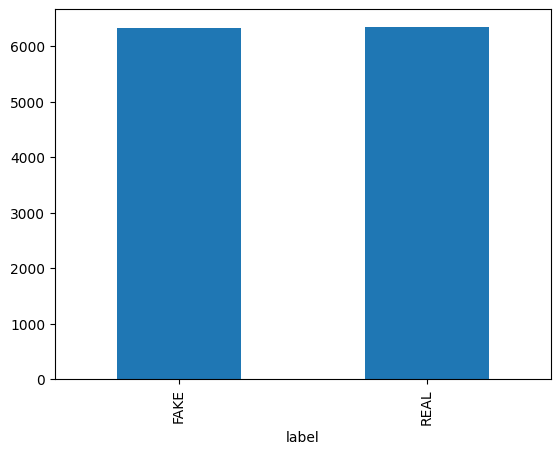

In [47]:
# How many articles per subject?
print(data.groupby(['label'])['text'].count())
data.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

target
fake    6335
true    6335
Name: text, dtype: int64


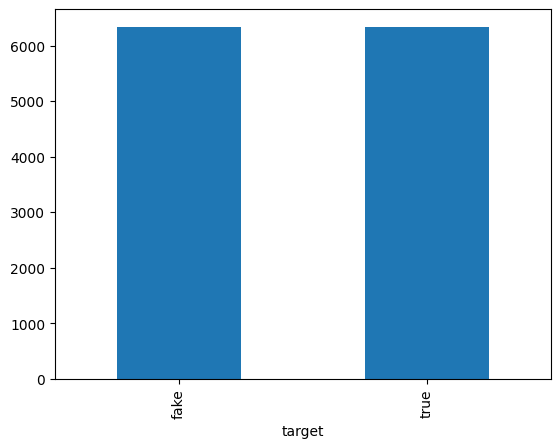

In [48]:
# How many articles per subject?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

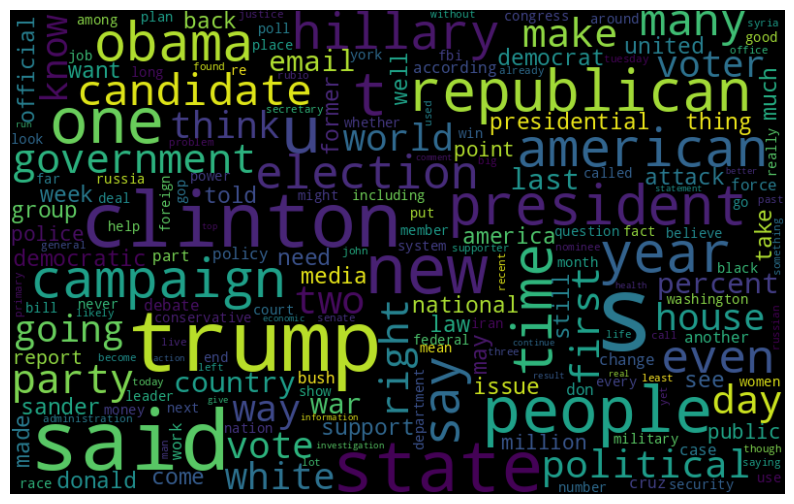

In [49]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

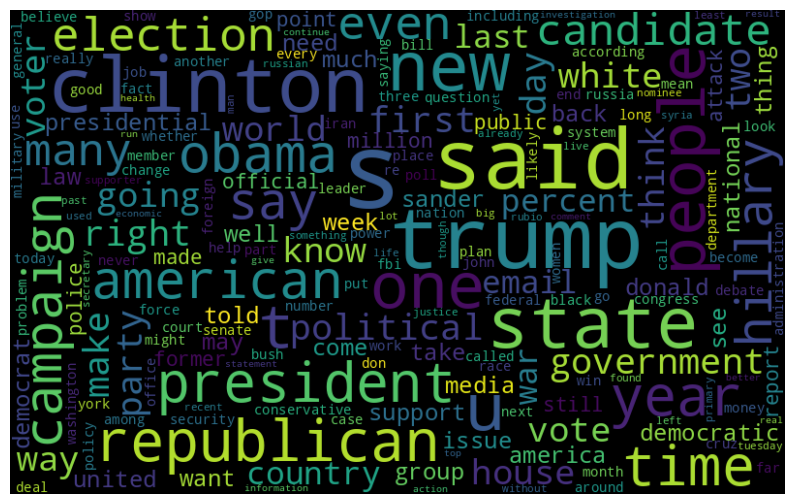

In [50]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

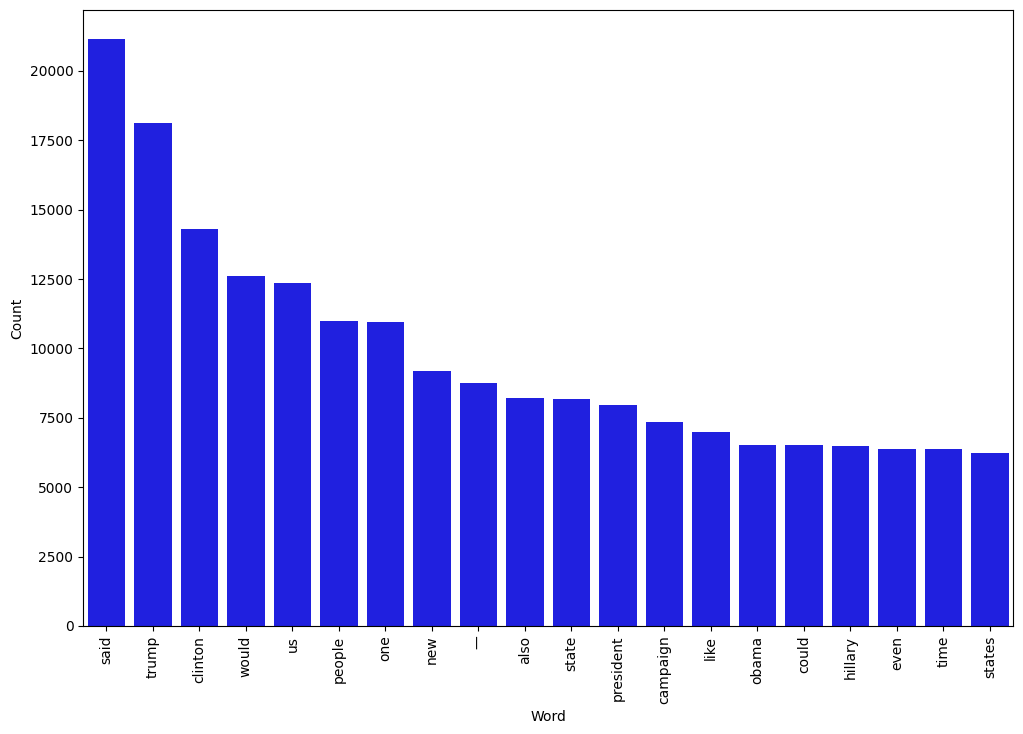

In [52]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

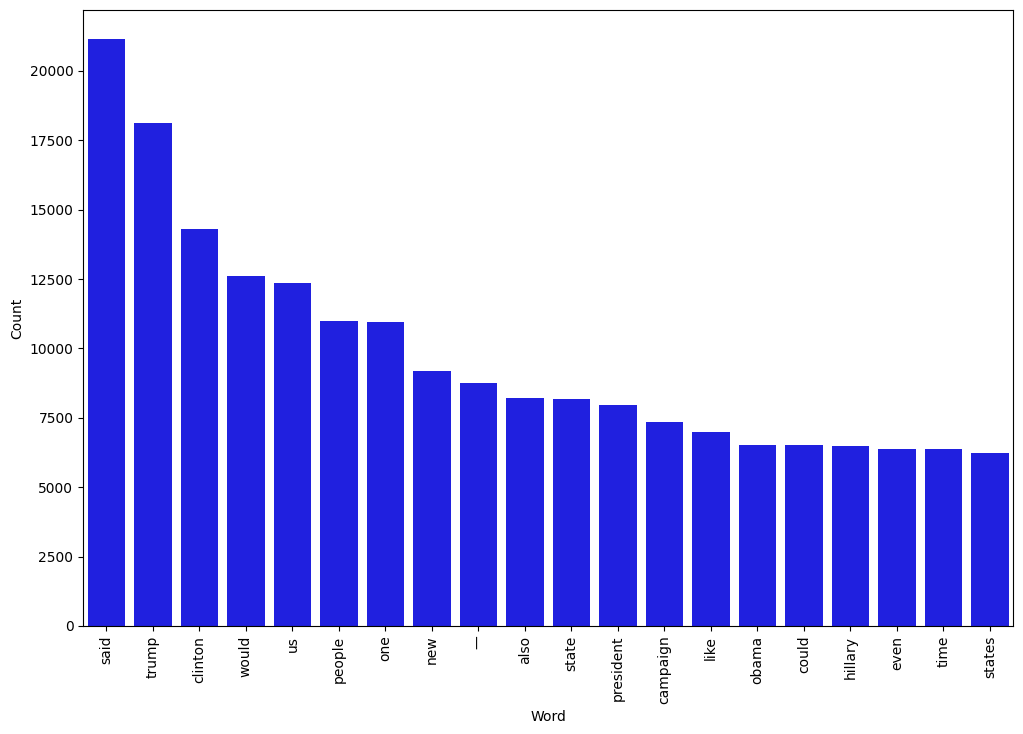

In [53]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

# Modeling

In [54]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Peparing The Data

In [55]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# Naive Bayes

In [56]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 12.19%


Confusion matrix, without normalization


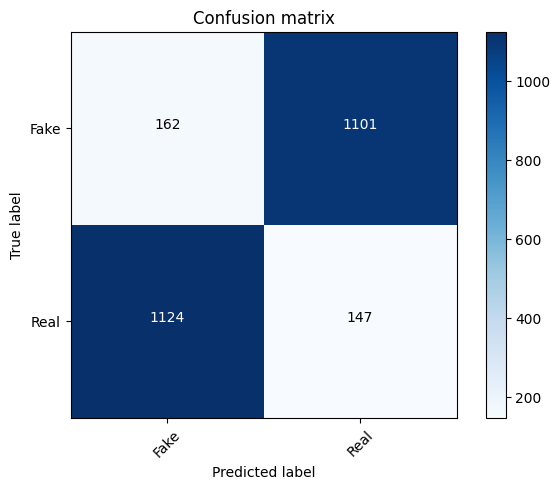

In [57]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Logistic Regression

In [58]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 13.65%


Confusion matrix, without normalization


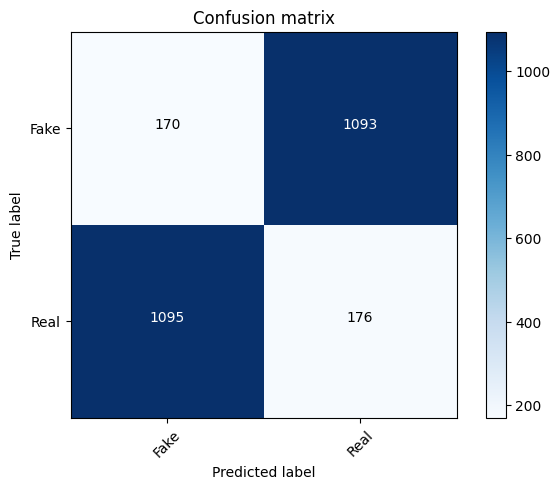

In [59]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Decision Tree

In [60]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20,
                                           splitter='best',
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 47.43%


Confusion matrix, without normalization


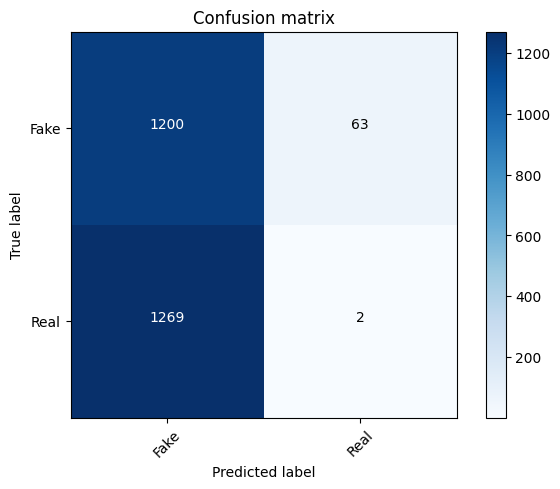

In [61]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# SVM

In [62]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 15.04%


Confusion matrix, without normalization


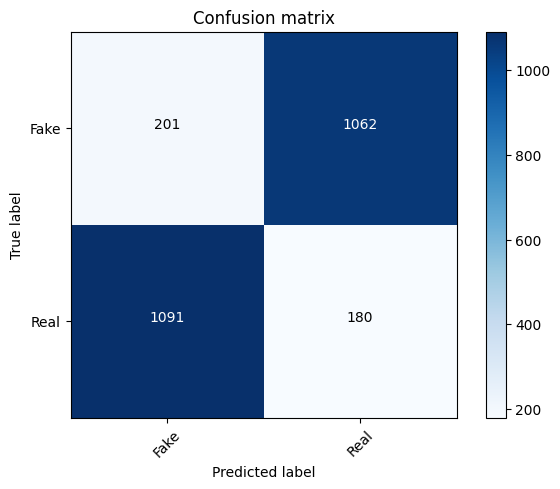

In [63]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Comparing Different Models

([<matplotlib.axis.YTick at 0x7ea6be5ec970>,
 [Text(0, 91, '91'),
  Text(0, 92, '92'),
  Text(0, 93, '93'),
  Text(0, 94, '94'),
  Text(0, 95, '95'),
  Text(0, 96, '96'),
  Text(0, 97, '97'),
  Text(0, 98, '98'),
  Text(0, 99, '99'),
  Text(0, 100, '100')])

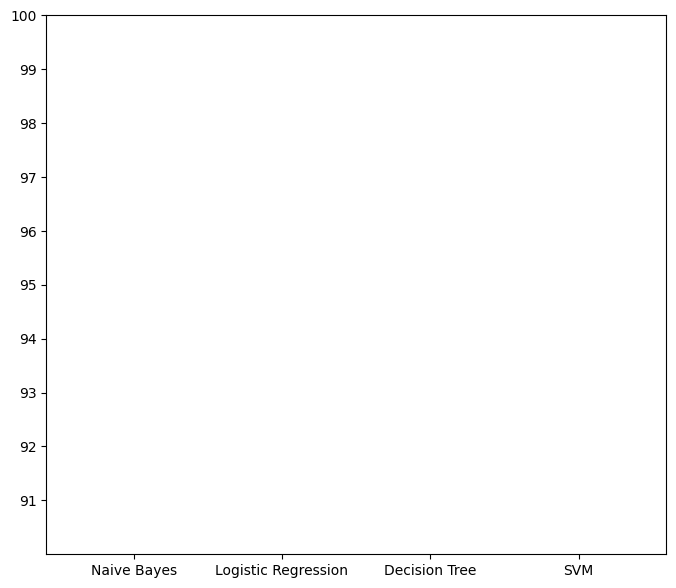

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))